<a href="https://colab.research.google.com/github/felixzhao/HARDataset/blob/main/Halter_V2_HAR_non_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [54]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# load data

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
prefix_path = "drive/MyDrive/UCI_HAR_Dataset"

## train data

In [57]:
class HARFeatureLoader:
    def __init__(self, root_path):
        self.root = root_path
        features_path = f'{prefix_path}/features.txt'
        self.x_train_path = f'{prefix_path}/train/X_train.txt'
        self.subject_train_path = f'{prefix_path}/train/subject_train.txt'
        self.label_dict = {
            1: 'WALKING', 
            2:'WALKING_UPSTAIRS',
            3:'WALKING_DOWNSTAIRS',
            4:'SITTING', 
            5:'STANDING',
            6:'LAYING'
            }
        self.feature_names = self._load_features_names(features_path)
        self.train_df = None
        self.test_df = None

    def _load_features_names(self, path:str):
        feature_names = []
        with open(path) as f:
            feature_names = [line.split()[1] for line in f.readlines()]
        return feature_names

    def _generate_path(self, split_type:str):
        x_path = f'{prefix_path}/{split_type}/X_{split_type}.txt'
        subject_path = f'{prefix_path}/{split_type}/subject_{split_type}.txt'
        y_path = f'{prefix_path}/{split_type}/y_{split_type}.txt'
        return x_path, subject_path, y_path

    def _remove_duplicate_columns(self, df):
        df_copy = df.copy()

        # find duplicate column names
        duplicate_cols = df_copy.columns.duplicated()

        # drop duplicate columns
        return df_copy.drop(df_copy.columns[duplicate_cols], axis=1)

    def _load(self, x_path, subject_path, y_path):
        x = pd.read_csv(x_path, delim_whitespace=True, header=None)
        x.columns = [self.feature_names]
        x['subject'] = pd.read_csv(subject_path, header=None, squeeze=True)
        y = pd.read_csv(y_path, names=['Activity'], squeeze=True)
        y_labels = y.map(self.label_dict)
        df = x
        df['Activity'] = y
        df['ActivityName'] = y_labels
        return df

    def _load_features(self, df):
        raw_df = self._remove_duplicate_columns(df)
        columns = raw_df.columns \
                        .get_level_values(0) \
                        .str.replace('[()]','') \
                        .str.replace('[-]', '') \
                        .str.replace('[,]','')
        raw_df.columns = columns
        x = raw_df.drop(['subject', 'Activity', 'ActivityName'], axis=1)
        y = raw_df.ActivityName
        print(f'{x.shape=}, {y.shape=}')
        return x, y


    def load_train(self):
        print('load train data.')
        x_path, subject_path, y_path = self._generate_path('train')
        self.train_df = self._load(x_path, subject_path, y_path)
        return self._load_features(self.train_df)

    def load_test(self):
        print('load test data.')
        x_path, subject_path, y_path = self._generate_path('test')
        self.train_df = self._load(x_path, subject_path, y_path)
        return self._load_features(self.train_df)
  

# load data by loader

In [73]:
loader = HARFeatureLoader(prefix_path)
X_train, y_train = loader.load_train()
X_test, y_test = loader.load_test()

load train data.
x.shape=(7352, 435), y.shape=(7352,)
load test data.
x.shape=(2947, 435), y.shape=(2947,)


In [74]:
labels=list(loader.label_dict.values())

## XGBoots

In [75]:
param_grid = {'n_estimators':np.arange(2)}
gbdt = XGBClassifier()
# model = GridSearchCV(gbdt, param_grid=param_grid, n_jobs=-1)

In [76]:
gbdt.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [77]:
y_pred = gbdt.predict(X_test)
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
print(accuracy)

0.9382422802850356


Text(113.09375, 0.5, 'True')

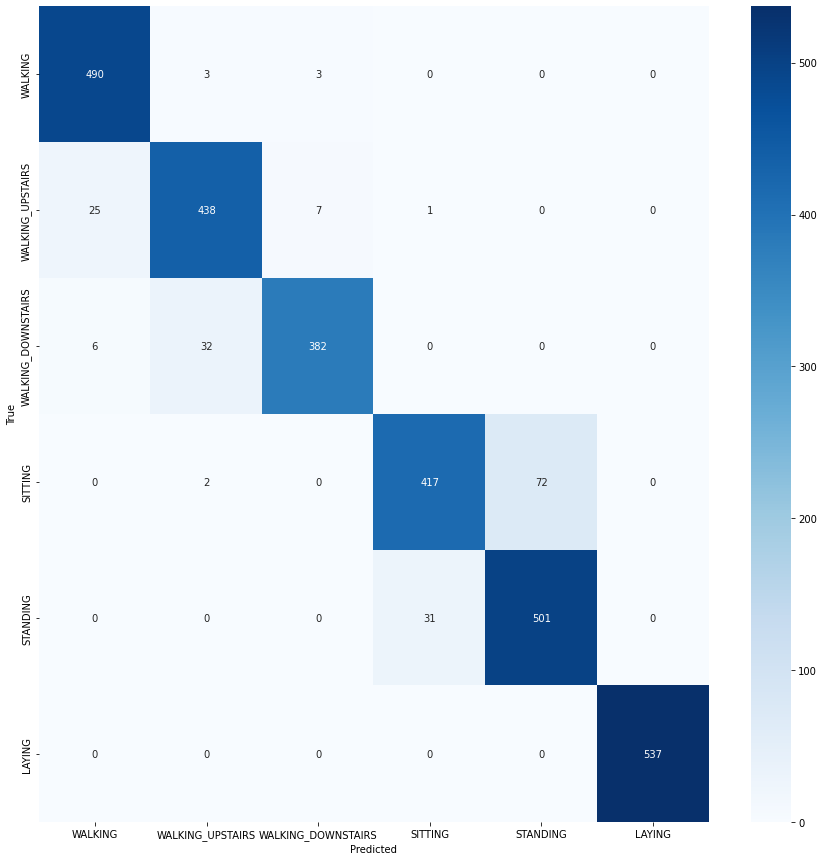

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))
# make predictions on the test set
y_pred = gbdt.predict(X_test)

# create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')